\begin{center}
\textbf{Authors} \\
Mattia Zanin - \href{mailto:mattia.zanin@studenti.unipd.it}{\texttt{mattia.zanin@studenti.unipd.it}} \\
Matteo Giorgi - \href{mailto:matteo.giorgi.1@tudenti.unipd.it}{\texttt{matteo.giorgi.1@tudenti.unipd.it}} \\
Enrico Zanello - \href{mailto:enrico.zanello@studenti.unipd.it}{\texttt{enrico.zanello@studenti.unipd.it}} \\
Luca Lo Buono - \href{mailto:luca.lobuono@studenti.unipd.it}{\texttt{luca.lobuono@studenti.unipd.it}}

\vspace{1cm}
\end{center}

# Time-Series Forecasting (`series_1`)

## Train/Test split (time-ordered)

We evaluate forecasting performance out-of-sample using a time-ordered split.
The last `H` observations are kept as test set, while the remaining observations are used for training.
This mirrors the real forecasting setting where future data are not available at estimation time.


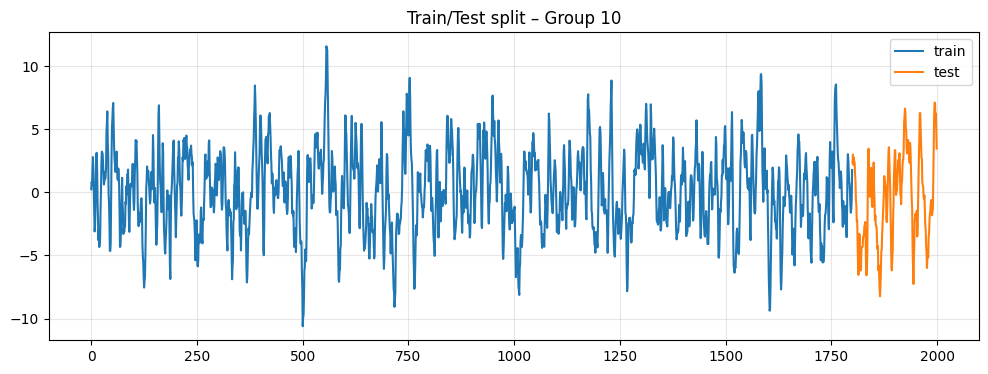

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load series_1 column from the CSV file
df = pd.read_csv("arma12_seasonal_controlled_15series.csv")
y = df["series_1"].astype(float).to_numpy()

# test horizon
H = 200
y_train, y_test = y[:-H], y[-H:]

# Plot the train/test split
plt.figure(figsize=(12, 4))
plt.plot(y_train, label="train")
plt.plot(np.arange(len(y_train), len(y)), y_test, label="test")
plt.title("Train/Test split – Group 10")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

The figure shows the time-ordered split between the training and test sets.
The training sample is used to estimate the model parameters, while the test sample represents future observations not available at estimation time.

The absence of evident structural breaks and the similar variability across the two subsamples support the use of a stationary ARMA specification.

## Model fitting

Following the Box–Jenkins methodology introduced in the previous assignment, 
we fit an ARMA(p,q) model to the training set of `series_1`.
Model choice is guided by parsimony and standard diagnostic criteria.

> For consistency and simplicity, we consider an ARMA(1,2) specification, 
which provides a flexible yet parsimonious representation for short-term dynamics.


In [2]:
from statsmodels.tsa.arima.model import ARIMA

# ARMA(1,2) = ARIMA(1,0,2)
# with trend set to "n" (no trend)
fit = ARIMA(y_train, order=(1, 0, 2), trend="n").fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1800
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2590.840
Date:                Tue, 16 Dec 2025   AIC                           5189.680
Time:                        14:53:49   BIC                           5211.663
Sample:                             0   HQIC                          5197.795
                               - 1800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7637      0.016     46.391      0.000       0.731       0.796
ma.L1          0.7158      0.021     33.947      0.000       0.675       0.757
ma.L2          0.5405      0.022     25.050      0.0

## Point forecasts and accuracy

We produce H-step-ahead forecasts for the test period and evaluate accuracy using standard loss functions (MAE and RMSE).

<!-- The main forecasting exercise is based on a static estimation of the model, 
where parameters are fixed using the training set and forecasts are generated out-of-sample.
As a robustness check, we also consider a rolling one-step-ahead forecasting scheme, 
which represents a *dynamic evaluation* of predictive performance. -->



MAE: 2.9387423675426305
RMSE: 3.562957258644348


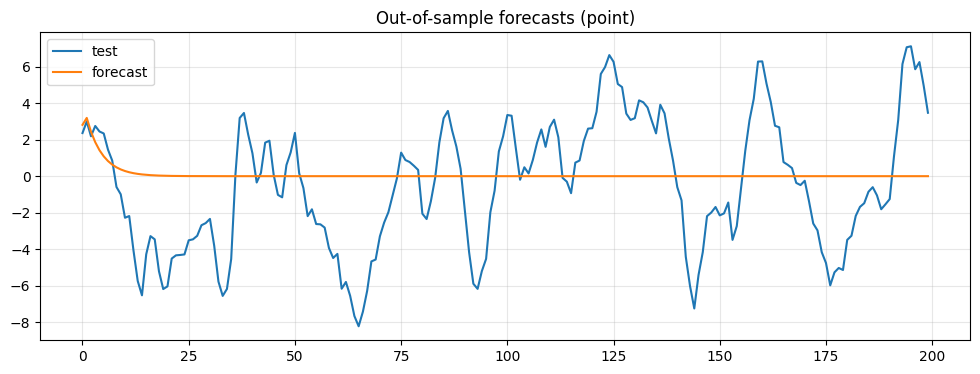

In [3]:
# Generate out-of-sample forecasts
# and use predicted mean as point forecasts
pred = fit.get_forecast(steps=H)
y_hat = pred.predicted_mean

# Evaluate forecasts
mae = np.mean(np.abs(y_test - y_hat))
rmse = np.sqrt(np.mean((y_test - y_hat) ** 2))
print("MAE:", mae)
print("RMSE:", rmse)

# Plot the forecasts against the test set
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="test")
plt.plot(y_hat, label="forecast")
plt.title("Out-of-sample forecasts (point)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

The figure reports the dynamic multi-step out-of-sample forecasts compared with the realized test observations.
As expected for a stationary ARMA model, the forecast rapidly converges to the unconditional mean of the process, resulting in a flat long-horizon prediction.

This behavior highlights the limited long-term predictability of the series and motivates the use of rolling one-step-ahead forecasts for improved short-term accuracy.

### Rolling 1-step (static forecast)

As a robustness check, we also consider a rolling one-step-ahead forecasting scheme.

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Rolling forecasts (empty list to hold forecasts)
history = list(y_train)
roll_forecasts = []

# Generate rolling forecasts with a loop
for t in range(H):
    m = ARIMA(history, order=(1, 0, 2), trend="n").fit()
    roll_forecasts.append(m.forecast(steps=1)[0])
    history.append(y_test[t])

# Convert list to numpy array because we will do numerical operations
roll_forecasts = np.array(roll_forecasts)

# Evaluate rolling forecasts with MAE and RMSE
mae_r = np.mean(np.abs(y_test - roll_forecasts))
rmse_r = np.sqrt(np.mean((y_test - roll_forecasts) ** 2))
print("Rolling MAE:", mae_r)
print("Rolling RMSE:", rmse_r)

Rolling MAE: 0.8003453839215822
Rolling RMSE: 1.0208109076601994


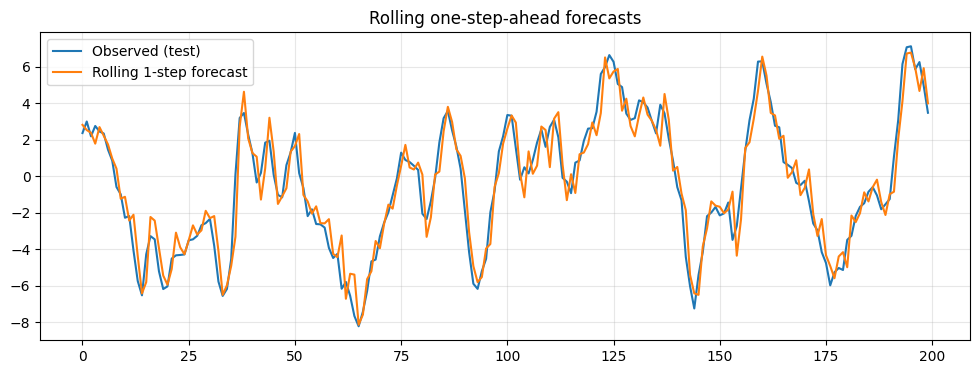

In [5]:
# Plot rolling forecasts against the test set
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="Observed (test)")
plt.plot(roll_forecasts, label="Rolling 1-step forecast")
plt.title("Rolling one-step-ahead forecasts")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

The rolling one-step-ahead forecasts closely track the observed test values.
By incorporating newly observed information at each time step, this static forecasting scheme adapts to local fluctuations and substantially improves short-term predictive accuracy compared to the dynamic multi-step forecast.

## Interval forecasts

We compute 95% prediction intervals. In a correct ARMA specification, most test observations should fall within these bands, and the interval width reflects forecast uncertainty increasing with the horizon.

The empirical coverage is close to the nominal level, indicating well-calibrated prediction intervals.


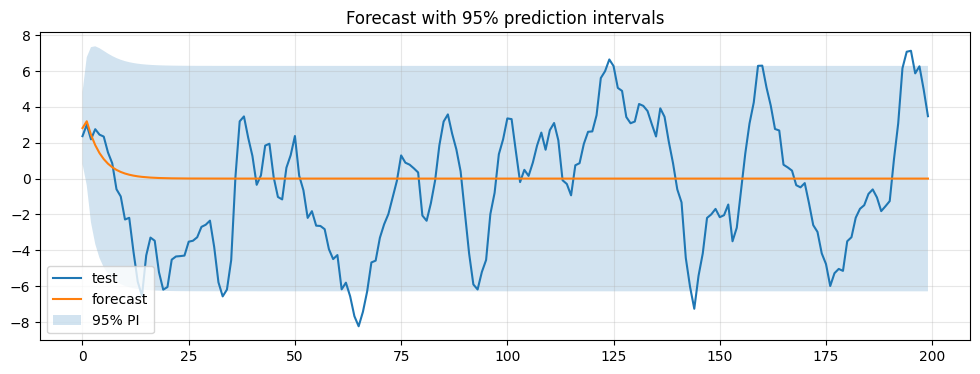

Empirical coverage: 0.935


In [6]:
# Use confidence intervals to plot prediction intervals
ci = pred.conf_int(alpha=0.05)  # 95%
lower = ci[:, 0]
upper = ci[:, 1]

# Plot the forecasts with prediction intervals
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="test")
plt.plot(y_hat, label="forecast")
plt.fill_between(np.arange(H), lower, upper, alpha=0.2, label="95% PI")
plt.title("Forecast with 95% prediction intervals")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Calculate empirical coverage of the prediction intervals
coverage = np.mean((y_test >= lower) & (y_test <= upper))
print("Empirical coverage:", coverage)

## Benchmark comparison

We compare ARMA forecasts against a simple naive benchmark: $\hat{y}_{t+1}=y_t$.
Despite its simplicity, the naive model is often hard to beat in short-horizon forecasting.


In [7]:
# Forecast at t uses previous observed value
# and it does not use any model (naive forecast)
naive = np.r_[y_train[-1], y_test[:-1]]
mae_n = np.mean(np.abs(y_test - naive))
rmse_n = np.sqrt(np.mean((y_test - naive) ** 2))

# Print naive forecast evaluation
print("Naive MAE:", mae_n)
print("Naive RMSE:", rmse_n)

Naive MAE: 0.9588742508332725
Naive RMSE: 1.2114453879620386


# Conclusions

In this assignment we performed out-of-sample forecasting on `series_1` using an ARMA model estimated on a training sample.

Dynamic multi-step forecasts converge rapidly to the unconditional mean of the process, reflecting the limited long-horizon predictability of a stationary ARMA model.
Forecast effectiveness was therefore evaluated using both point accuracy measures and prediction intervals.

A rolling one-step-ahead forecasting scheme was also considered as a static evaluation strategy.\
By incorporating newly observed information at each time step, the rolling approach substantially improves short-term predictive accuracy, as confirmed by lower MAE and RMSE values.

Overall, the results highlight the distinction between dynamic and static forecasting and emphasize the importance of evaluation design in time series prediction.


\bibliographystyle{alpha}
\bibliography{references}